In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from pandas.plotting import scatter_matrix
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler


In [2]:
ar = pd.read_csv('../wk4/audit_risk.csv')
tr = pd.read_csv('../wk4/trial.csv')
print(ar.shape)
print(tr.shape)

(776, 27)
(776, 18)


In [3]:
# comapre column names 
ar_cols = ar.columns
tr_cols = tr.columns

common_cols = ar_cols.intersection(tr_cols)
ar_not_tr = ar_cols.difference(tr_cols)
tr_not_ar = tr_cols.difference(ar_cols)

# modify common column names to compare their row values
# Risk has different values in ar and tr, rest of the common columns have the same values
tr.rename(columns={'Risk':'aRisk'}, inplace=True)

ar_cols = ar.columns
tr_cols = tr.columns
tr_not_ar = tr_cols.difference(ar_cols)

df = pd.concat([ar,tr[tr_not_ar]], axis=1)
df.shape

(776, 36)

In [4]:
df.isnull().values.sum()

# Money_value and aMoney_value have Nan
df[df.isnull().any(1)]

# fill NAN with mean
colname = list(df)

x = colname[12] # 'Money_Value'

print('Money_Value with NaN:',df.loc[:,x].sum())

df[x] = df[x].fillna(df[x].mean())

print('Repalce NaN with mean:',df.loc[:,x].sum())


Money_Value with NaN: 10956.663999999999
Repalce NaN with mean: 10970.80163096774


In [5]:
print(colname)

['Sector_score', 'LOCATION_ID', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B', 'Score_B', 'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C', 'Money_Value', 'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E', 'History', 'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK', 'Detection_Risk', 'Audit_Risk', 'Risk', 'District', 'History_score', 'LOSS_SCORE', 'Loss', 'MONEY_Marks', 'Marks', 'SCORE_A', 'SCORE_B', 'aRisk']


In [6]:
# select columns based on their types
flo_vars = list(df.select_dtypes(include=[np.float64]))
int_vars = list(df.select_dtypes(include=[np.int64]))

# select columns with less than 2 unique values :Detection_Risk'
less2 =[]
for flo in flo_vars:
    a = len(np.unique(df[flo]))
    if a < 2:
        print(flo,', unique values:', a)
        less2.append(flo)
print(less2)        

Detection_Risk , unique values: 1
['Detection_Risk']


In [7]:
# drop "Detection_Risk"
df = df.drop(['Detection_Risk'], axis=1)

In [8]:
# reorganize column types
dfnames = list(df)

new_flo= list(set(flo_vars)-set(less2))
new_int = list(set(dfnames) -set(new_flo))
print(len(new_flo),len(new_int))

22 13


In [9]:
# Using seaborn pairplot to see the bivariate relation between each pair of features
import seaborn as sns
sns.set()

#sns.pairplot(df[new_int],size = 2 ,kind ='scatter')
#plt.show()

In [10]:
# Using seaborn pairplot to see the bivariate relation between each pair of features
import seaborn as sns
sns.set()

#sns.pairplot(df[new_flo],size = 2 ,kind ='scatter')
#plt.show()

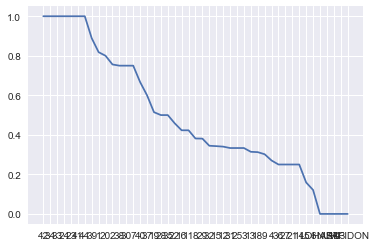

In [11]:
a=df[["LOCATION_ID","Risk"]].groupby("LOCATION_ID").mean().sort_values(by="Risk", ascending=False)

# Risk varies in some LOCATION_IDs
# Need transform location_id

plt.plot(a.index,a['Risk'])
plt.show()

In [12]:
a =[]
for i in df.LOCATION_ID:
    if i == 'SAFIDON':
        new_val = 101
    elif i == 'NUH':
        new_val = 102
    elif i == 'LOHARU':
        new_val = 1003
    else:
        new_val = int(i)
    a.append(new_val)
    #df.LOCATION_ID.replace(i,new_val)
df.LOCATION_ID = a

In [13]:
# define independent and dependent variables
# split data
colname = list(df)
var = colname[1:24]+colname[25:35] 
 
X = df[var]
y = df['Audit_Risk']

X_train_mm, X_test_mm, y_train, y_test = train_test_split(X, y, random_state =15678 , test_size = 0.15)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train_mm)
X_test  = scaler.transform(X_test_mm)
y_train = np.log1p(y_train)
y_test  = np.log1p(y_test)

# inverse of log1p
real_ytest=np.expm1(y_test)

## Bagging 1 (Decision Tree)

In [14]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

grid_values = {'max_depth': [ 5, 10, 20, 50, 100]}

dt_clf = DecisionTreeRegressor(random_state=12345)
grid_clf = GridSearchCV(dt_clf,cv = 5, param_grid = grid_values)

grid_clf.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf.predict(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)
print('Grid best score (accuracy): ', grid_clf.best_score_)


Grid best parameter (max. accuracy):  {'max_depth': 10}
Grid best score (accuracy):  0.9691727974000607


In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score


# fitting test with the best parameter
dtclf = DecisionTreeRegressor(**grid_clf.best_params_)
dtclf.fit(X_test, y_test) 

y_test_predict = dtclf.predict(X_test)

print("Mean squared error (Decision Tree): {:.2f}".format(mean_squared_error(y_test, y_test_predict)))
print('MSE:',np.square(y_test_predict-y_test).mean())
print("r2_score (Bag Decision Tree): {:.2f}".format(r2_score(y_test, y_test_predict )))

Mean squared error (Decision Tree): 0.00
MSE: 3.115275071586659e-08
r2_score (Bag Decision Tree): 1.00


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

bag_clf = BaggingRegressor(dtclf, n_estimators=20, max_samples=300, bootstrap=True, n_jobs=-1, random_state=123)
bag_clf.fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

y_predict = bag_clf.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)

#print('Bag Decision Tree, coefficients: ', bag_clf.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (Bag Decision Tree): {:.2f}".format(mean_squared_error(y_test, y_predict)))
#print('MSE:',np.square(y_predict-real_ytest).mean())

print("r2_score (dummy): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (Bag Decision Tree): {:.2f}".format(r2_score(y_test, y_predict)))

Mean squared error (dummy): 1.09
Mean squared error (Bag Decision Tree): 0.03
r2_score (dummy): -0.00
r2_score (Bag Decision Tree): 0.98


###  Bagging 2 (Ridge regression)

In [17]:
from  sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

grid_values = {'n_estimators': [ 10, 50, 100],
              'max_samples':   [ 10, 50, 100, 200]}

ridge = Ridge()

bag_clf = BaggingRegressor(ridge, bootstrap=True, n_jobs=-1, random_state=123)
grid_clf = GridSearchCV(bag_clf, cv = 5, param_grid = grid_values)

grid_clf.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)
print('Grid best score (accuracy): ', grid_clf.best_score_)

Grid best parameter (max. accuracy):  {'max_samples': 10, 'n_estimators': 50}
Grid best score (accuracy):  0.8694079412176553


In [18]:
# Apply best parameters

bag_clf = BaggingRegressor(ridge,**grid_clf.best_params_, bootstrap=True, n_jobs=-1, random_state=1234,)
bag_clf.fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

y_predict = bag_clf.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)


print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (Bag: Ridge Regression): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print('MSE (Bag: Ridge Regression):',np.square(y_predict-y_test).mean())

print("r2_score (dummy): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (Bag: Linear Regression): {:.2f}".format(r2_score(y_test, y_predict)))

#422620407157.9463 (MSE from no feature engineering data)
#0.11089856029768168(MSE from feature engineering data)

Mean squared error (dummy): 1.09
Mean squared error (Bag: Ridge Regression): 0.13
MSE (Bag: Ridge Regression): 0.13044143389772386
r2_score (dummy): -0.00
r2_score (Bag: Linear Regression): 0.88


###  Past 1 (Random Forest)

In [19]:
# Grid search 

from sklearn.ensemble import RandomForestRegressor

grid_values = {'max_depth': [ 10, 50, 100, 200, 500],
              'max_leaf_nodes': [ 10, 20, 50, 100, 200]}


rf_clf = RandomForestRegressor(random_state=12345)
grid_clf = GridSearchCV(rf_clf,cv = 5, param_grid = grid_values)


grid_clf.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf.predict(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)
print('Grid best score (accuracy): ', grid_clf.best_score_)

Grid best parameter (max. accuracy):  {'max_depth': 10, 'max_leaf_nodes': 200}
Grid best score (accuracy):  0.977017070908517


In [20]:
# fitting test with the best parameter

from sklearn.metrics import mean_squared_error

rfclf = RandomForestRegressor(**grid_clf.best_params_)

pasting_clf = BaggingRegressor(rfclf, n_estimators=20, max_samples=300, bootstrap=False, n_jobs=-1, random_state=123)
pasting_clf.fit(X_train, y_train)


y_test_predict = pasting_clf.predict(X_test)

print("Mean squared error (Decision Tree): {:.2f}".format(mean_squared_error(y_test, y_test_predict)))
print('MSE:',np.square(y_test_predict-y_test).mean())
print("r2_score (Bag: Decision Tree): {:.2f}".format(r2_score(y_test, y_test_predict )))


Mean squared error (Decision Tree): 0.03
MSE: 0.025376443543549346
r2_score (Bag: Decision Tree): 0.98


### Pasting 2 (Ridge Regression)

In [21]:

pasting_ln = BaggingRegressor(ridge, max_samples = 10, n_estimators = 100, bootstrap=False, n_jobs=-1, random_state=1234,)
pasting_ln.fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

y_predict = pasting_ln.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)


print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (Bag: Linear Regression): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print('MSE (Bag: Linear Regression):',np.square(y_predict-y_test).mean())

print("r2_score (dummy): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (Bag: Linear Regression): {:.2f}".format(r2_score(y_test, y_predict)))


Mean squared error (dummy): 1.09
Mean squared error (Bag: Linear Regression): 0.10
MSE (Bag: Linear Regression): 0.10444841682297287
r2_score (dummy): -0.00
r2_score (Bag: Linear Regression): 0.90


###  Adaboost 1 (Decision tree)

In [22]:
## need to redesign
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

# Decision Tree parameters are adapted from previou result  

grid_values = {'n_estimators': [ 10, 50, 100, 200, 500],
              'learning_rate': [ 0.1, 0.2, 0.5, 0.8]}

ada_clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20), random_state=1234)

grid_clf = GridSearchCV(ada_clf, cv = 5, param_grid = grid_values)

grid_clf.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)
print('Grid best score (accuracy): ', grid_clf.best_score_)

Grid best parameter (max. accuracy):  {'learning_rate': 0.5, 'n_estimators': 50}
Grid best score (accuracy):  0.9794418653893204


In [23]:
# Apply best parameters

ada_clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),**grid_clf.best_params_,random_state=1234)

ada_clf.fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

y_predict = ada_clf.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)


#print('Bag Decision Tree, coefficients: ', bag_clf.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (Ada: DecisionTree): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print('MSE (Ada: DecisionTree):',np.square(y_predict-y_test).mean())

print("r2_score (dummy): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (Ada: DecisionTree): {:.2f}".format(r2_score(y_test, y_predict)))

#0.004746733420304831 (MSE from no feature engineering data)
#0.006141016463740285 (MSE from  feature engineering data)
#0.009387713021158374 (MSE from reduced feature engineering data)

Mean squared error (dummy): 1.09
Mean squared error (Ada: DecisionTree): 0.00
MSE (Ada: DecisionTree): 0.004746733420304831
r2_score (dummy): -0.00
r2_score (Ada: DecisionTree): 1.00


### Adaboost 2 (Linear Regression)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor

lreg = LinearRegression()
ada_clf = AdaBoostRegressor(lreg, n_estimators = 200, learning_rate= 0.8,random_state=1234)

ada_clf.fit(X_train, y_train)
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

y_predict = ada_clf.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)


#print('Bag Decision Tree, coefficients: ', bag_clf.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (Ada Linear Regression): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print('MSE (Ada Linear Regression):',np.square(y_predict-y_test).mean())

print("r2_score (dummy): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (Ada Linear Regression): {:.2f}".format(r2_score(y_test, y_predict)))


Mean squared error (dummy): 1.09
Mean squared error (Ada Linear Regression): 0.08
MSE (Ada Linear Regression): 0.0793039242585043
r2_score (dummy): -0.00
r2_score (Ada Linear Regression): 0.93


### Gradient Boosting (Decision Tree)

In [25]:
from  sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Decision Tree parameters are adapted from previou result  

grid_values = {'max_depth'  : [ 5, 10, 20, 50],
              'n_estimators': [ 10, 50, 100, 200, 500],
              'learning_rate': [ 0.1, 0.2, 0.5, 0.8]}


gbrt = GradientBoostingRegressor(random_state=42)

grid_clf = GridSearchCV(gbrt, cv = 5, param_grid = grid_values)

grid_clf.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)
print('Grid best score (accuracy): ', grid_clf.best_score_)

Grid best parameter (max. accuracy):  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Grid best score (accuracy):  0.983931489807433


In [26]:
# Apply best parameters

gbrt = GradientBoostingRegressor(**grid_clf.best_params_, random_state=42)
gbrt.fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

y_predict = gbrt.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)


#print('Bag Decision Tree, coefficients: ', bag_clf.coef_)
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))
print("Mean squared error (gbrt): {:.2f}".format(mean_squared_error(y_test, y_predict)))
print('MSE (gbrt):',np.square(y_predict-y_test).mean())

print("r2_score (dummy): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (gbrt): {:.2f}".format(r2_score(y_test, y_predict)))

# (MSE from no feature engineering data)
#0.022455599574399694(MSE from feature engineering data)

Mean squared error (dummy): 1.09
Mean squared error (gbrt): 0.03
MSE (gbrt): 0.02904358251314917
r2_score (dummy): -0.00
r2_score (gbrt): 0.97


<IPython.core.display.Javascript object>


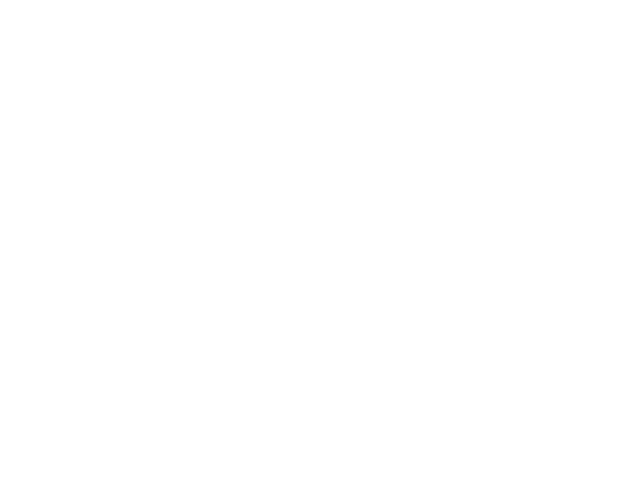

([<matplotlib.axis.YTick at 0x19f8c8c0b70>,
 <a list of 33 Text yticklabel objects>)

In [27]:
%matplotlib notebook

y_list = gbrt.feature_importances_
y_pos = np.arange(len(y_list))
features = var
plt.barh(y_pos, y_list, align='center', alpha=0.4)
plt.yticks(y_pos, features)

### Regression Neural networks

In [28]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.wrappers.scikit_learn import KerasClassifier

C:\Users\clfee\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [29]:
from pylab import *

batch_size = 15
epochs = 300

#Define the model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(33, input_dim=33, kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(8, kernel_initializer='normal'))    
    model.add(Dense(4, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))

   # Compile model
    #model.compile(loss='mse', optimizer='adam' , metrics = ['mse'])
    model.compile(optimizer=optimizers.RMSprop(lr=0.005), loss='mean_squared_error', metrics=['mse'])
    #model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['accuracy'])
    return model

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='regr', monitor='val_loss', save_best_only=True)]

In [30]:
#Use the model
seed = 1025
np.random.seed(seed)
regr = baseline_model()
#es = EarlyStopping(monitor ='val_loss', patience=2)
csv_logger = CSVLogger('training.log')
regr_fit = regr.fit(X_train,y_train, epochs = epochs,batch_size = batch_size, 
                    verbose = 1, validation_split = 0.1,callbacks =callbacks)

Train on 593 samples, validate on 66 samples
Epoch 1/300
593/593 [==============================] - 2s 3ms/step - loss: 0.7505 - mean_squared_error: 0.7505 - val_loss: 0.0702 - val_mean_squared_error: 0.0702
Epoch 2/300
593/593 [==============================] - 0s 371us/step - loss: 0.1693 - mean_squared_error: 0.1693 - val_loss: 0.1969 - val_mean_squared_error: 0.1969
Epoch 3/300
593/593 [==============================] - 0s 277us/step - loss: 0.1406 - mean_squared_error: 0.1406 - val_loss: 0.1354 - val_mean_squared_error: 0.1354


In [31]:
regr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 33)                1122      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 272       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 1,435
Trainable params: 1,435
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Model evaluation
score = regr.evaluate(X_test, y_test, verbose = 0)
print('test loss:', score[0])

test loss: 0.1559222787618637


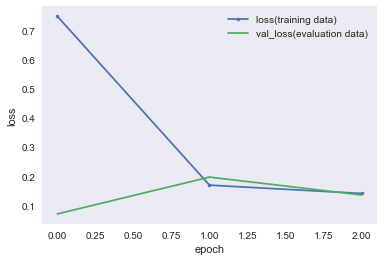

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt
# Learning rersults
loss = regr_fit.history['loss']
val_loss = regr_fit.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs),loss, marker = '.', label = 'loss(training data)')
plt.plot(range(epochs),val_loss, marker = ',', label = 'val_loss(evaluation data)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [35]:
# Neuron network Results
from sklearn.metrics import mean_squared_error, r2_score

y_test_predict = regr.predict(X_test)

MSE_nn = (mean_squared_error(y_test, y_test_predict))

print('MSE_nn:', MSE_nn)

MSE_nn: 0.15592228468742358


### PCA

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#scaler = MinMaxScaler()
scaler = StandardScaler()
X_reduced = scaler.fit_transform(X)

#create model
pca = PCA(n_components = 0.95)

#train PCA model
pca.fit(X_reduced)
#transform C-train and X_test
X_scaled = pca.transform(X_reduced)

# Split train and test

X_train_mm, X_test_mm, y_train, y_test = train_test_split(X_scaled, y, random_state =15678 , test_size = 0.15)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train_mm)
X_test  = scaler.transform(X_test_mm)
y_train = np.log1p(y_train)
y_test  = np.log1p(y_test)

### PCA LASSO and Ridge

In [38]:
# LASSO
from sklearn.linear_model import Lasso
x_range = [0.001]
train_score_list = []
test_score_list = []

for alpha in x_range: 
    lasso = Lasso(alpha)
    lasso.fit(X_train,y_train)
    train_score_list.append(lasso.score(X_train,y_train))
    test_score_list.append(lasso.score(X_test, y_test))

y_test_predict = lasso.predict(X_test)

MSE_Lasso = (mean_squared_error(y_test, y_test_predict))

#print('MSE:',np.square(y_test_predict-y_test).mean())
print('MSE_Lasso:',MSE_Lasso)

# Ridge
from  sklearn.linear_model import Ridge

x_range = [0.01]
train_score_list = []
test_score_list = []

for alpha in x_range: 
    ridge = Ridge(alpha)
    ridge.fit(X_train,y_train)
    train_score_list.append(ridge.score(X_train,y_train))
    test_score_list.append(ridge.score(X_test, y_test))

y_test_predict = ridge.predict(X_test)
MSE_Ridge = (mean_squared_error(y_test, y_test_predict))

print('MSE_Ridge:', MSE_Ridge)

MSE_Lasso: 0.06941575715891418
MSE_Ridge: 0.06897054642049116


### PCA KNN

In [39]:
from sklearn.neighbors import KNeighborsRegressor 
k = 2
knn_reg = KNeighborsRegressor(k)

knn_reg.fit(X_train, y_train)
y_test_predict = knn_reg.predict(X_test)


MSE_KNN = (mean_squared_error(y_test, y_test_predict))
print('MSE:', MSE_KNN)

MSE: 0.07792009597310275


### SGD Regressor 

In [41]:
### PCA Linear Regression and Polynomial Regression

from sklearn.linear_model import LinearRegression

lreg = LinearRegression()
lreg.fit(X_train, y_train)

y_test_predict = lreg.predict(X_test)

MSE_lin = (mean_squared_error(y_test, y_test_predict))

print('MSE_lin:', MSE_lin)

## Poly ##

from  sklearn.preprocessing  import PolynomialFeatures

lreg = LinearRegression()

n =2
poly = PolynomialFeatures(n)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
lreg.fit(X_train_poly, y_train)

train_score = lreg.score(X_train_poly, y_train)
test_score =lreg.score(X_test_poly, y_test)

y_test_predict = lreg.predict(X_test_poly)

MSE_poly = (mean_squared_error(y_test, y_test_predict))

print('MSE_poly:', MSE_poly)

MSE_lin: 0.06897079693322726
MSE_poly: 0.142711866805924


### SGD Regressor and LinearSVR

In [42]:
from sklearn.linear_model import SGDRegressor

a = 0.1
n= X_train.shape[0]

# Fit regression model
sgd_reg = SGDRegressor(random_state= 8364, alpha = a, max_iter = np.ceil(10**6/n), learning_rate = 'optimal', penalty = 'l2')
sgd_reg.fit(X_train, y_train)

y_test_predict = sgd_reg.predict(X_test)

MSE_sgd = (mean_squared_error(y_test, y_test_predict))

print('MSE_sgd:', MSE_sgd)

##

# LinearSVR 
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

grid_values = {'epsilon': [0.005, 0.01, 0.1, 1, 10, 100],
              'C': [0.005, 0.01, 0.1, 1, 10, 100]}

clf = LinearSVR(dual=True, fit_intercept=True,intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,random_state=843647, tol=1e-04, verbose=0)

#clf = LinearSVR()
grid_clf = GridSearchCV(clf, cv = 5, param_grid = grid_values)

grid_clf.fit(X_train, y_train)

#y_decision_fn_scores_acc = grid_clf.predict(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)

bclf = LinearSVR(**grid_clf.best_params_)
bclf.fit(X_test, y_test) 
y_test_predict = bclf.predict(X_test)

MSE_lnSVR = (mean_squared_error(y_test, y_test_predict))

print('MSE_lnSVR:', MSE_lnSVR)


MSE_sgd: 0.07669210284950974
Grid best parameter (max. accuracy):  {'C': 0.01, 'epsilon': 0.1}
MSE_lnSVR: 0.615377813594834


### SVR RBF, SVR linear, and SVR poly

In [43]:
# SVR RBF
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

grid_values = {'gamma': [0.01, 0.1, 1, 10, 100],
              'C': [0.01, 0.1, 1, 10, 100]}

svr_rbf = SVR(kernel='rbf')

grid_clf = GridSearchCV(svr_rbf, cv = 5, param_grid = grid_values)

grid_clf.fit(X_train, y_train)

#y_decision_fn_scores_acc = grid_clf.predict(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)

bclf = SVR(kernel = 'rbf',**grid_clf.best_params_)
bclf.fit(X_test, y_test) 
y_test_predict = bclf.predict(X_test)

MSE_rbf = (mean_squared_error(y_test, y_test_predict))

print('MSE_rbf:', MSE_rbf)

## SVR Linear
# SVR Linear Kernel 
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

grid_values = {'C': [0.01, 0.1, 1, 10, 100]}

svr_lin = SVR(kernel='linear')
svr_lin.fit(X_train, y_train)

grid_clf = GridSearchCV(svr_lin, cv = 5, param_grid = grid_values)

grid_clf.fit(X_train, y_train)

#y_decision_fn_scores_acc = grid_clf.predict(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)

bclf = SVR(kernel = 'linear',**grid_clf.best_params_)
bclf.fit(X_test, y_test) 
y_test_predict = bclf.predict(X_test)

MSE_svr_klin = (mean_squared_error(y_test, y_test_predict))

print('MSE_svr_klin:', MSE_svr_klin)

## SVR Poly

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

grid_values = {'C': [0.01, 0.1, 1, 10, 100]}

svr_poly = SVR(kernel='poly', gamma='auto', degree=3, epsilon=.1, coef0=1)

grid_clf = GridSearchCV(svr_poly, cv = 5, param_grid = grid_values)
grid_clf.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf.best_params_)

bclf = SVR(kernel='poly', gamma='auto', degree=3, epsilon=.1, coef0=1,**grid_clf.best_params_)
bclf.fit(X_test, y_test) 
y_test_predict = bclf.predict(X_test)

MSE_svr_poly = (mean_squared_error(y_test, y_test_predict))

print('MSE_svr_poly:', MSE_svr_poly)

Grid best parameter (max. accuracy):  {'C': 10, 'gamma': 0.01}
MSE_rbf: 0.014132621584839687
Grid best parameter (max. accuracy):  {'C': 0.01}
MSE_svr_klin: 0.30305006754697034
Grid best parameter (max. accuracy):  {'C': 0.01}
MSE_svr_poly: 0.4961704952121145


In [44]:
PCA_results = [MSE_Lasso, MSE_Ridge, MSE_KNN, MSE_lin, MSE_poly, MSE_sgd, MSE_lnSVR, MSE_rbf, MSE_svr_klin, MSE_svr_poly]
print('PCA :',PCA_results)

PCA : [0.06941575715891418, 0.06897054642049116, 0.07792009597310275, 0.06897079693322726, 0.142711866805924, 0.07669210284950974, 0.615377813594834, 0.014132621584839687, 0.30305006754697034, 0.4961704952121145]


In [45]:
names = ['MSE_Lasso', 'MSE_Ridge', 'MSE_KNN', 'MSE_lin', 'MSE_poly', 'MSE_sgd', 'MSE_lnSVR', 'MSE_rbf', 'MSE_svr_klin', 'MSE_svr_poly']
ori_results = [0.08457264245950262, 0.07675642061237507, 0.06641509150901805, 0.08814859779051516, 6.745690914003219e+17, 419475915966.3876, 0.04700171203107682, 0.006493656796008494, 0.06400080623040187, 0.022436990864133175]
PCA_results = [MSE_Lasso, MSE_Ridge, MSE_KNN, MSE_lin, MSE_poly, MSE_sgd, MSE_lnSVR, MSE_rbf, MSE_svr_klin, MSE_svr_poly]

titles = ['ori_results','names', 'PCA_results']
data = [titles] + list(zip(ori_results, names,  PCA_results))

for i, d in enumerate(data):
    line = '   |'.join(str(x).ljust(12) for x in d)
    print(line)
    if i == 0:
        print('-' * len(line))


ori_results    |names          |PCA_results 
--------------------------------------------
0.08457264245950262   |MSE_Lasso      |0.06941575715891418
0.07675642061237507   |MSE_Ridge      |0.06897054642049116
0.06641509150901805   |MSE_KNN        |0.07792009597310275
0.08814859779051516   |MSE_lin        |0.06897079693322726
6.745690914003219e+17   |MSE_poly       |0.142711866805924
419475915966.3876   |MSE_sgd        |0.07669210284950974
0.04700171203107682   |MSE_lnSVR      |0.615377813594834
0.006493656796008494   |MSE_rbf        |0.014132621584839687
0.06400080623040187   |MSE_svr_klin   |0.30305006754697034
0.022436990864133175   |MSE_svr_poly   |0.4961704952121145


In [49]:
dif = []
ori_results = np.array(ori_results)
PCA_results = np.array(PCA_results)
dif =(ori_results-PCA_results)/ori_results
x = list(zip(names,  dif))
print(x)

[('MSE_Lasso', 0.17921735516123044), ('MSE_Ridge', 0.10143612911815002), ('MSE_KNN', -0.1732287677797224), ('MSE_lin', 0.21756217725509236), ('MSE_poly', 1.0), ('MSE_sgd', 0.9999999999998171), ('MSE_lnSVR', -12.092668054047808), ('MSE_rbf', -1.1763733484539396), ('MSE_svr_klin', -3.7350976557388194), ('MSE_svr_poly', -21.113950048679282)]


### PCA vs No PCA


- PCA helped to obtain better results in the  Polynomial regression and SGD models. The MSEs were much larger without PCA   
  treatment.
- On the other hand, PCA did not help to obtain better result, as MSE were more than 10 times larger after PCA treatment in the 
  linear SVR, SVR linear (with kernel trick), and SVR polynomial models.
- The MSEs were quite similar with or without PCA in the rest of the modes.
